The content of this notebook follows part 1 of Andrej Karpathy's terrific Makemore  tutorial (https://www.youtube.com/watch?v=PaCmpygFfXo)

In [ ]:
import numpy as np
import torch
!git clone https://github.com/karpathy/makemore

fatal: destination path 'makemore' already exists and is not an empty directory.


In [ ]:
with open('makemore/names.txt','r') as file:
  words = file.read().splitlines()

In [ ]:
word_lengths = [len(w) for w in words]
print(
 f"""
 This dataset contains {len(word_lengths)} names\n
 The minimum name length is {min(word_lengths)} characters.\n 
 The maximum name length is {max(word_lengths)} characters.\n
 The mean name length is  {np.mean(word_lengths):.2f} characters. \n
 The associated standard deviation is {np.std(word_lengths):.2f} characters.
 """
 )


 This dataset contains 32033 names

 The minimum name length is 2 characters.
 
 The maximum name length is 15 characters.

 The mean name length is  6.12 characters. 

 The associated standard deviation is 1.44 characters.
 


In [ ]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


## Bigrams

In [ ]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>'] # start and end indicators
  for ch1, ch2 in zip(chs,chs[1:]):
    bigram = (ch1,ch2)
    b[bigram] = b.get(bigram, 0)+1
    #print(ch1,ch2)


In [ ]:
#sorted(b.items(), key = lambda d: -d[1])

In [ ]:
# 26 letters in the alphabet, +1 special character to represent start and end (different from above)
chars = ['.']+sorted(list(set(''.join(words)))) 
s_to_i = {s:i for i,s in enumerate(chars)}

In [ ]:
N = torch.zeros((27,27), dtype=torch.int32)
for w in words:
  chs = ['.'] + list(w) + ['.'] # start and end indicators
  for ch1, ch2 in zip(chs,chs[1:]):
    N[s_to_i[ch1], s_to_i[ch2]] += 1 

In [ ]:
i_to_s = {i:s for s,i in s_to_i.items()}

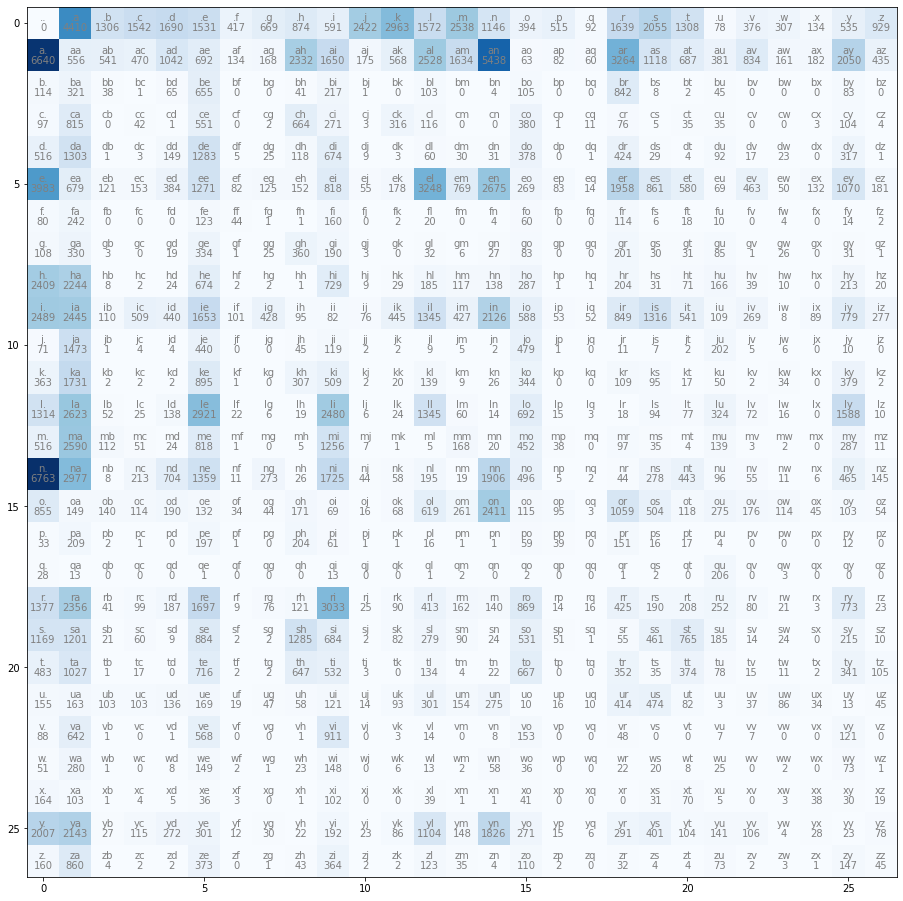

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for ii in range(27):
  for jj in range(27):
    chstr = i_to_s[ii] + i_to_s[jj]
    plt.text(jj,ii, chstr, ha="center", va="bottom", color='gray')
    plt.text(jj,ii, N[ii,jj].item(), ha="center", va="top", color='gray')
plt.show()

In [ ]:
# From frequencies to probabilities
# This N matrix is essentially a transition probability matrix --> rows need to be normalized
#P = N.float()
# A problem with just using the count data is that there are pairs of characters, e.g., 'zq', which never occured in the training data.
# It is plausible that someone has a name including the sequence 'zq'. Since our model for P based on just counts N places zero probability
# on the pair 'zq', such a name will never occur. Scoring a name including 'zq' with the model's log likelihood would then produce a value of 
# -inf. We can add in fake counts to do some model smoothing.

P = (1+N).float()
P /= N.sum(dim=1, keepdim=True)

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for ii in range(20):
  out = []
  ix=0
  while True:
    
    ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
    out.append(i_to_s[ix])
    if ix==0: #end character
      break

  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.


Unsurprisingly, bigram models are not very good at representing natural names

In [ ]:
 # Scoring the model
log_likelihood = 0
n = 0 
for w in words:
  chs = ['.'] + list(w) + ['.'] # start and end indicators
  for ch1, ch2 in zip(chs,chs[1:]):
    log_likelihood += torch.log(P[s_to_i[ch1], s_to_i[ch2]]) #natural log
    n += 1

In [ ]:
print(f'The log likelihood of our data is {log_likelihood}\n')
nll = -log_likelihood
print(f'The negative log likelihood (nll) of our data is {nll}\n')
print(f'The average nll of our data is {nll/n}\n')
nll_rand = -torch.log(torch.as_tensor(1/27.0))
print(f'For reference, the average nll of our data under a purely random model is {nll_rand}')
print(f'Hence our model is better than random. This is good, but nothing to celebrate about.')

The log likelihood of our data is -559322.6875

The negative log likelihood (nll) of our data is 559322.6875

The average nll of our data is 2.4515998363494873

For reference, the average nll of our data under a purely random model is 3.295836925506592
Hence our model is better than random. This is good, but nothing to celebrate about.


In the context of model building, the data-model we have constructed is the transition probability $P$. Hence, the parameters of this model are the entries of the matrix P. Naturally, these parameters are constrained to be non-negative and normalized such that $P1 = 1$. The class of such models $\{P: P \ge 0, P1=1\}$ is a convex set. The training of this model $P$ was conducted above by computing frequencies-of-occurance in the names corpus and using them as probability estimates.

An obvious problem with this model is that it accounts for only relationships between the current character and the next character, i.e., $\mathbb{P}(x_{n+1} | x_n)$. 

## Simple single-layer neural network version of the bigram model

In [ ]:
#create training set of all bigrams (x,y)
#first, we will load all data as indices
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.'] # start and end indicators
  for ch1, ch2 in zip(chs,chs[1:]):
    xs.append(s_to_i[ch1]) #indices to 
    ys.append(s_to_i[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [ ]:
print(num)

228146


In [ ]:
import torch.nn.functional as F

In [ ]:
#initializing parameters 
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(size=(27, 27), generator=g, requires_grad=True) #27 inputs, 27 outputs (goal: P(output character | input character))

In [ ]:
#minimizing the nll loss through gradient descent (no)
n_epochs = 10
lr = 0.1

for ii in range(n_epochs):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() #convert the indices to one-hot vectors and then convert to float for the neural network.
  logits = xenc @ W #"log counts"
  # not that since xenc is just a one-hot vector, it just selects a single row from W
  counts = logits.exp()
  probs = counts / counts.sum(dim=1, keepdims=True) #i-th output is the probability distribution over the 27 characters, given character i_to_s[ xs[i] ]
  loss = -probs[torch.arange(num), ys].log().mean()  + 0.01*(W**2).mean() #added regularization

  # backward pass
  W.grad = None #efficient way of setting to zero
  loss.backward()
  #print(loss)
  # update
  W.data += -lr*W.grad

print(loss)

tensor(2.4808, grad_fn=<AddBackward0>)


In [ ]:
# sampling from the NN model

g = torch.Generator().manual_seed(2147483647)

for ii in range(20):
  out = []
  ix=0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predicted "log counts"
    counts = logits.exp() # predicted counts
    probs = counts / counts.sum(dim=1, keepdims=True)

    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(i_to_s[ix])
    if ix==0: #end character
      break

  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchthizarie.
odaren.
iaddash.
h.
jionatien.
egwulo.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoyonutonadengin.


We have essentially recovered our previous bigram model in which the transition probability model $P$ was built by filling in frequencies-of-occurrence. Although, the gradient-based approach produced identical results, it is more extensible to sophisticated models of $P$ that go beyond just using bigram statistics as training data. 